In [1]:
import numpy as np
import math 
import queue
import os
import neat
import visualize
import random
import matplotlib.pyplot as plt
import pickle

import GameManager
from GameManager import map_manager, Tile, Unit, Team

import Neat_AI
from Neat_AI import eval_genomes, run

import AI_modules
from AI_modules import no_ai, rand_ai, script_ai, neat_ai, script_performance

In [2]:
local_dir = os.path.abspath('')
config_path = os.path.join(local_dir, 'config-feedforward')

In [4]:
dimensions = (8,8)
manager = map_manager(dimensions)
#print(manager)

manager.setup_layouts_rand(layout_n=10, unit_count=5)
for i in range(len(manager.map_layouts)):
    manager.apply_map_layout(i)
    #print(manager)
    

In [ ]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
#also resets map
manager.setup_rand(units_per_side)
print(manager)

while (manager.game_joever() == -1 and manager.turn_count < 8): #Turn Count limit may have to be modified
    for unit in manager.Teams[manager.curr_team].live_units:
        win_move = (0, 0)
        if manager.curr_team == 0:
            win_move = neat_ai(manager, unit, win_net)
        elif manager.curr_team == 1:
            win_move = script_ai(manager, unit)\
            #win_move = neat_ai(manager, unit, win_net)
        manager.move_unit(unit, win_move)
        print(manager)
    manager.Turn()

In [29]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
script_performance(manager, win_net, config)

In [77]:
from importlib import reload
reload(GameManager)
reload(AI_modules)
reload(Neat_AI)


from GameManager import map_manager, Tile, Unit, Team
from Neat_AI import eval_genomes, run, load_net
from AI_modules import no_ai, rand_ai, script_ai, neat_ai


 ****** Running generation 0 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 1 - id 1
Winrate vs. script : 0.0
eval_nets: []
Average adjusted fitness: 0.000
Mean genetic distance 2.224, standard deviation 0.791
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     5      0.0    0.000     0
Total extinctions: 0
Generation time: 3.040 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 1 - id 1
Winrate vs. script : 0.0
eval_nets: []
Average adjusted fitness: 0.000
Mean genetic distance 1.882, standard deviation 0.720
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1     5      0.0    0.000     1
Total extinctions: 0
Generation time: 2.954 sec (2.997 average)

 ****** Run

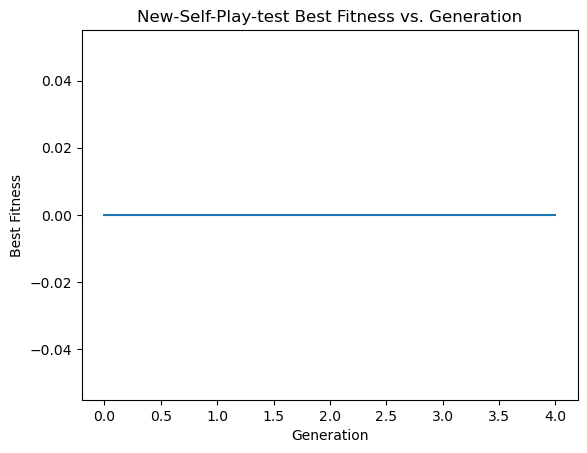

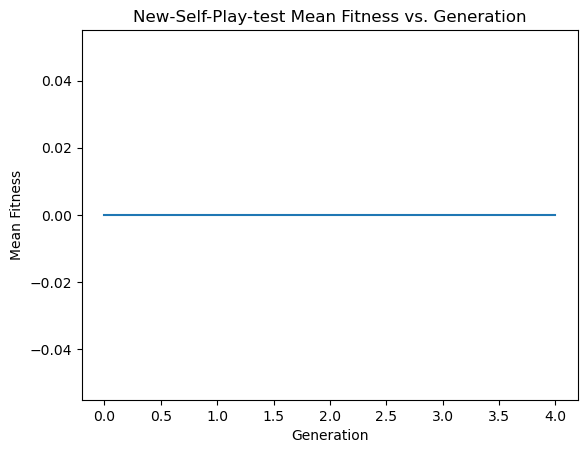

start: 0
end: 5


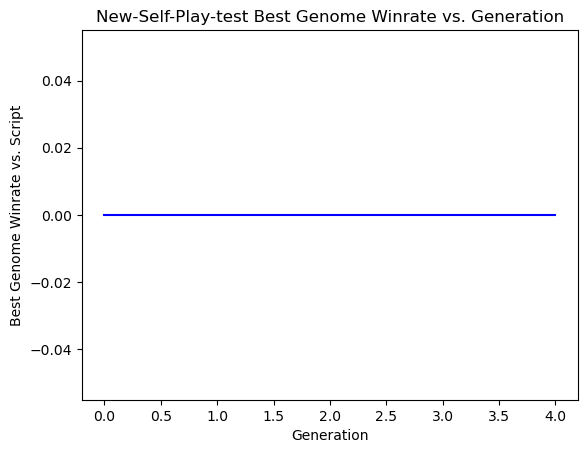

Average adjusted fitness: 0.000
Mean genetic distance 1.564, standard deviation 0.955
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4     5      0.0    0.000     4
Total extinctions: 0
Generation time: 3.355 sec (3.035 average)
Saving checkpoint to ./checkpoints/New-Self-Play-test/neat-checkpoint-4

 ****** Running generation 5 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 1 - id 1
Winrate vs. script : 0.0
eval_nets: [<neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E92A5BC10>]
1
Winrate vs. 1 : 0.0
Average adjusted fitness: 0.000
Mean genetic distance 1.355, standard deviation 0.988
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    5     5      0.0    0.000     5
Total extinctions: 0
Generation time: 5.583 sec (3.459 average)

 ****** Running gen

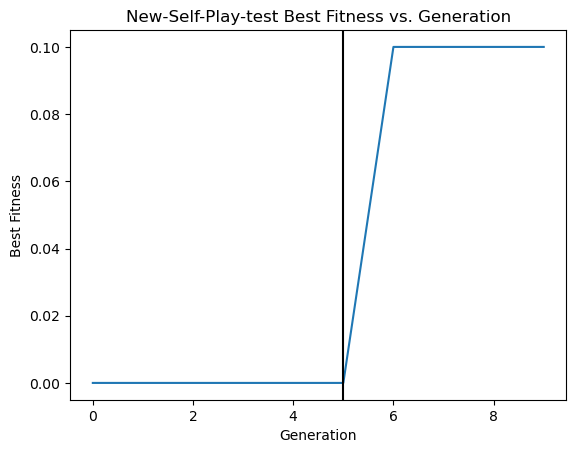

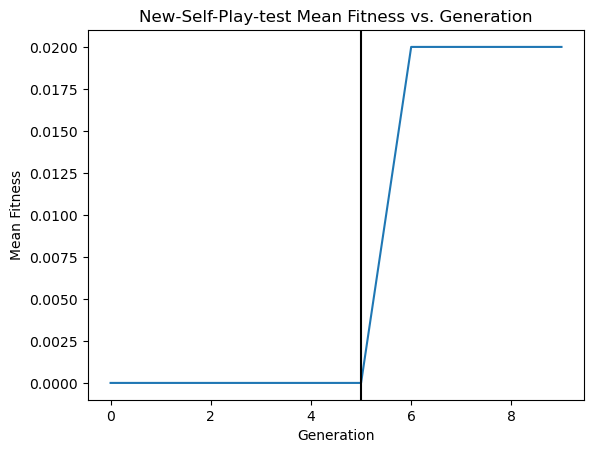

start: 0
end: 10
start: 5
end: 10


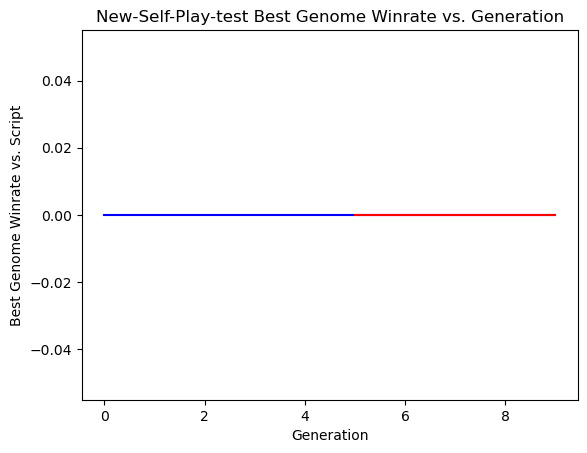

Average adjusted fitness: 0.020
Mean genetic distance 0.651, standard deviation 0.370
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9     5      0.1    0.020     3
Total extinctions: 0
Generation time: 5.039 sec (3.991 average)
Saving checkpoint to ./checkpoints/New-Self-Play-test/neat-checkpoint-9

 ****** Running generation 10 ****** 

Population's average fitness: 0.02000 stdev: 0.04000
Best fitness: 0.10000 - size: (1, 30) - species 1 - id 33
Winrate vs. script : 0.02
eval_nets: [<neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E92A5BC10>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E8E6AFC40>]
6
Winrate vs. 1 : 0.0
1
Winrate vs. 2 : 0.36
Average adjusted fitness: 0.020
Mean genetic distance 1.287, standard deviation 0.504
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   10     5      0.1  

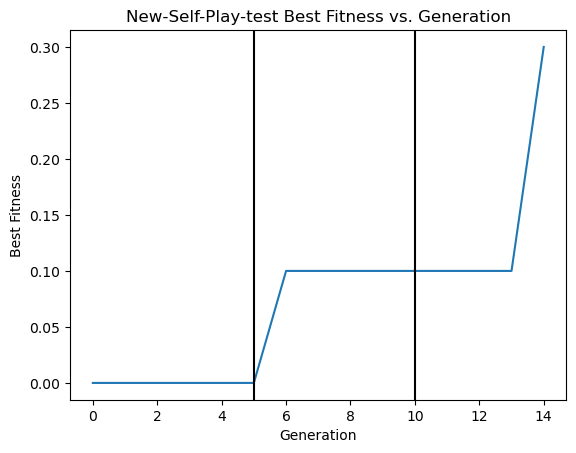

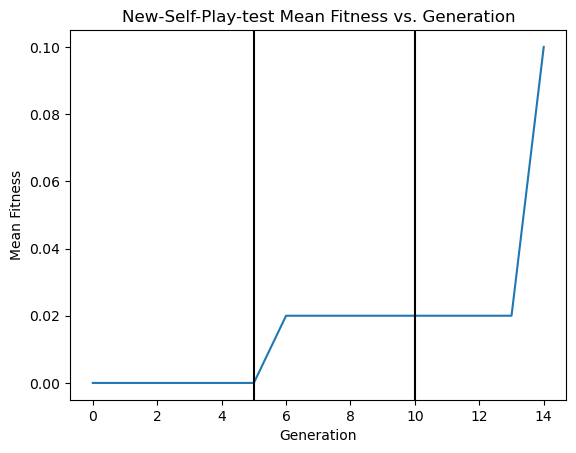

start: 0
end: 15
start: 5
end: 15
start: 10
end: 15


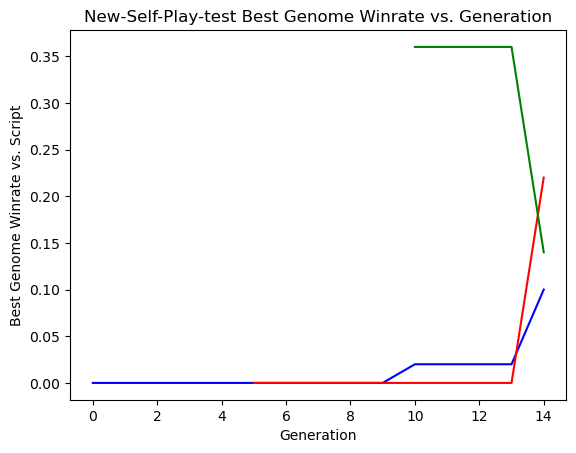

Average adjusted fitness: 0.100
Mean genetic distance 1.131, standard deviation 0.486
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14     5      0.3    0.100     0
Total extinctions: 0
Generation time: 7.623 sec (6.152 average)
Saving checkpoint to ./checkpoints/New-Self-Play-test/neat-checkpoint-14

 ****** Running generation 15 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (1, 29) - species 1 - id 46
Winrate vs. script : 0.1
eval_nets: [<neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E92A5BC10>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E8E6AFC40>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E927E3C10>]
11
Winrate vs. 1 : 0.22
6
Winrate vs. 2 : 0.14
1
Winrate vs. 3 : 0.0
Average adjusted fitness: 0.000
Mean genetic distance 0.517, standard deviation 0.314
Population of 5 members in 1 species:
   ID   age  siz

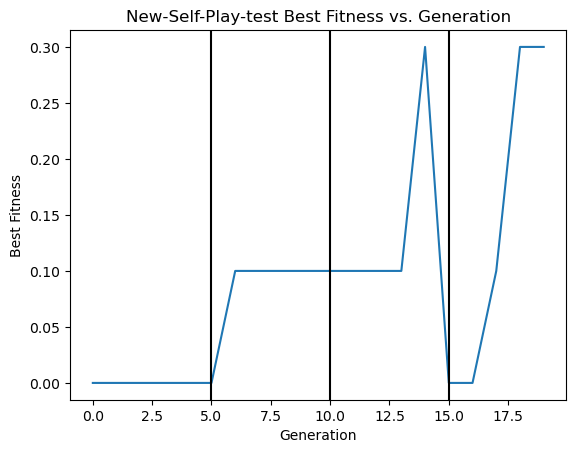

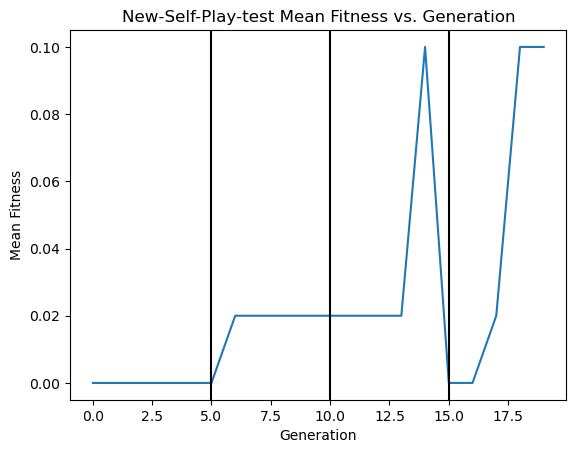

start: 0
end: 20
start: 5
end: 20
start: 10
end: 20
start: 15
end: 20


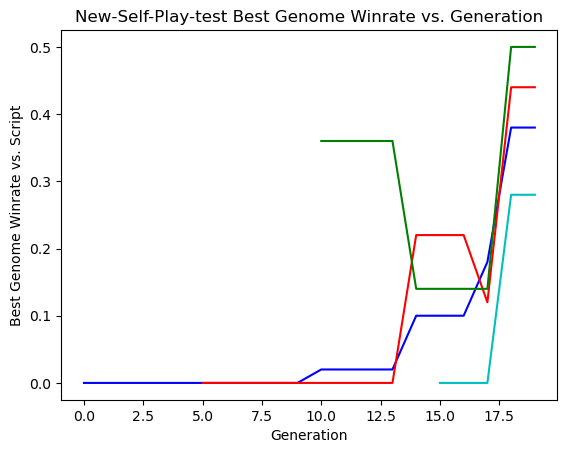

Average adjusted fitness: 0.100
Mean genetic distance 0.544, standard deviation 0.501
Population of 5 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19     5      0.3    0.100     5
Total extinctions: 0
Generation time: 8.335 sec (7.960 average)
Saving checkpoint to ./checkpoints/New-Self-Play-test/neat-checkpoint-19

 ****** Running generation 20 ****** 

Population's average fitness: 0.14000 stdev: 0.13565
Best fitness: 0.30000 - size: (1, 30) - species 1 - id 57
Winrate vs. script : 0.38
eval_nets: [<neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E92A5BC10>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E8E6AFC40>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E927E3C10>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x0000029E8B508F40>]
16
Winrate vs. 1 : 0.44
11
Winrate vs. 2 : 0.5
6
Winrate vs. 3 : 0.28
1
Winrate vs. 4 : 0.34
Average adjusted fitness: 0.140
Mean geneti

KeyboardInterrupt: 

In [78]:
random.seed(1748) #This is to set the random generated board starting positions
win_net, win_genome, stats = run(config_path, "New Self-Play test")

In [234]:
win_net1 = win_net
stats1 = stats

In [267]:
#Restore a checkpoint to resume Run
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

p = neat.checkpoint.Checkpointer.restore_checkpoint("./checkpoints/Global-Position-Eval-Func_vsScript_difference/neat-checkpoint-29")
winner = p.run(eval_genomes, 1)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

Mean genetic distance 1.323, standard deviation 0.442


In [172]:
#Restoring a best network for testing
net = load_net("./best/Relative-Position-Eval-Func-config", "./best/Relative-Position-Eval-Func-genome")
print(net)